In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 8.0 MB/s 
     |████████████████████████████████| 596 kB 64.8 MB/s 
     |████████████████████████████████| 3.3 MB 59.0 MB/s 
     |████████████████████████████████| 895 kB 76.9 MB/s 
     |████████████████████████████████| 56 kB 6.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### 라이브러리 다운로드

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cv2
from transformers import BertTokenizer, BertModel

import re
import os
import time
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import scipy.stats as ss
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data setting

In [ ]:
torch.manual_seed(777)
random.seed(777)
np.random.seed(777)

class_num = 300

def class_same(train_df, class_num):
  zero_df = train_df[train_df['label']==0][:class_num]
  one_df = train_df[train_df['label']==1][:class_num]
  total_df = pd.concat([zero_df, one_df])
  total_df = total_df.sample(frac=1).reset_index(drop=True)
  
  return total_df

def test_split(id, test_df):
  split_df = test_df[id*1000:(id+1)*1000]
  return split_df

yelp = pd.read_csv('/content/drive/My Drive/datasets/yelp.csv')
yelp['label'] = yelp['rating']-1
del yelp['rating']

train_df = yelp[:1000]
test_df = yelp[1000:-1000]
val_df = yelp[-1000:]

train_df = class_same(train_df, class_num)
test_df_1 = test_df[:10000]

title_order = ["NEG","POS"]

# total_tokens = [word_tokenize(sentence) for sentence in tqdm(yelp['review'])]

In [ ]:
# model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
vocab = list(tokenizer.vocab.keys())
word_dict = dict(tokenizer.vocab.items())

# 1. 모든 sentence에 CLS, SEP 붙인다.
def get_token(text):
    text = "[CLS] " + " [SEP] ".join(sent_tokenize(text)) + " [SEP]"
    tokenized_text = tokenizer.tokenize(text)
    return tokenized_text

# 2. token index로 변환, padding 한다.
def get_ids(tokenized_text, max_length):
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    if len(indexed_tokens) < max_length:
      input_ids = indexed_tokens + [0]*(max_length - len(indexed_tokens))
    else:
      input_ids = indexed_tokens[:max_length]
    
    return input_ids

# 3. segment_ids를 만든다.
def get_mask(input_ids):
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class BERT_CNN(Dataset):
    def __init__(self, df):

        def data_setting(df, max_len):

            #[CLS] [SEP] 붙임, token 변환
            description = list(df["review"])
            descriptions = [get_token(x) for x in description]
            description = [''.join(d) for d in descriptions]
            #max_len
            max_len=max_len      
            
            #convert Id + padding
            input_ids = [get_ids(x,max_len) for x in descriptions]
            
            #Attention_masks
            attention_masks = []
            attention_masks = get_mask(input_ids)
            
            #labels
            target = list(df['label'])
            
            # class수
            num_classes=len(df['label'].unique())
            
            return input_ids, target,  attention_masks, description

        input_ids, input_labels, attention_masks, description = data_setting(df, 512)

        self.reviews = description
        self.inputs = input_ids
        self.labels = input_labels
        self.masks = attention_masks

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):

        text = torch.tensor(self.inputs[idx])
        label = self.labels[idx]
        review = self.reviews[idx]
        mask = torch.LongTensor(self.masks[idx])

        return text, label, mask, review

In [ ]:
train_data = BERT_CNN(train_df)
train_loader = DataLoader(train_data, batch_size=2, num_workers=2, shuffle=True)

test_data = BERT_CNN(test_df_1)
test_loader = DataLoader(test_data, batch_size=2, num_workers=2, shuffle=False)

val_data = BERT_CNN(val_df)
val_loader = DataLoader(val_data, batch_size=2, num_workers=2, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Available devices ', torch.cuda.device_count())

Available devices  1


In [ ]:
class Net(nn.Module):
    '''
        encoded_layer : [layer, batch, sentence_len, embed_dim] # Bert 12-layer 결과중 하나 선택.
                        Conv1d 의 input로 들어가기 위해, [batch,sentence_len, embed_dim].unsqueeze(1)
                                                     => [batch, 1, sentence_len, embed_dim ]
        
        Conv1d input shape : 3D or 4D
        (sentence x embedding_dim) : 138 x 768 => (kernel_size = (3,768), padding=1)
                                     138 x 1 로 변환, padding로 인해 138유지.
                                     
        1짜리 차원 x.squeeze(3)    : [batch, 16, 138 , 1] =>  [batch, 16 , 138]
                                 
        
        Conv1d input : [batch, 1(number of channel) , sentence_len, emb_dim]
        Conv1d ouput : [batch, out_channel_num , sentence_len, emb_dim]
        
        [batch, out_channel_num , sentence_len, emb_dim].squeeze(3) 
        => [batch, out_channel_num , sentence_len] 
    '''
    def __init__(self, num_classes):
        super(Net,self).__init__()
        self.bert =  BertModel.from_pretrained('bert-base-uncased')
        self.conv1 = nn.Conv1d(1,16,kernel_size=(3,768))
        
        self.cnn = nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv1d(16,16,kernel_size=(3),padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm1d(16), 
            nn.MaxPool1d(2), 
            
            nn.Conv1d(16,32,kernel_size=(3),padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(32,32,kernel_size=(3),padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
            
            nn.Conv1d(32,64,kernel_size=(3),padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(64,64,kernel_size=(3),padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64,128,kernel_size=(3),padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(128,128,kernel_size=(3),padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1 * 31*128, 160), # width * height * channel_num 
            nn.Linear(160, num_classes)
        )
        self.relu = nn.LeakyReLU()
    def forward(self, inputs, masks):
        with torch.no_grad():
            encoded_layer = self.bert(inputs, masks)[0]
        encoded_layer = encoded_layer.unsqueeze(1)
        x = self.conv1(encoded_layer) 
        x = x.squeeze(3)
        x = self.cnn(x)
        x = x.view(-1,128*31)
        x = self.classifier(x)
        return x

In [ ]:
network = Net(len(train_df.label.unique()))

if torch.cuda.device_count() > 1:
    network = nn.DataParallel(network).to(device)
else:
    network = network.to(device)
#network.load_state_dict(torch.load('./save_model/variety_model.ckpt'))
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(network.parameters(), lr = 1e-3)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
network

Net(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        

In [ ]:
def main():
  epochs = 10
  total_loss = 0
  total_len = 0
  total_correct = 0
  network.train()
  for e in range(epochs):
      for i, (inputs, labels, masks, _) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.long().to(device)
          masks = masks.to(device)
          outputs = network(inputs, masks)
          loss = criterion(outputs, labels)

          pred = torch.argmax(F.softmax(outputs), dim=1)
          correct = pred.eq(labels)
          total_correct += correct.sum().item()
          total_len += len(labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          if (i+1) % 100 ==0:
              print(' Epoch [{} / {}] , step [{}/ {}] Loss: {: .4f} ACC: {: .2f}'
              .format(e +1, epochs, i+1, len(train_loader), loss.item(), total_correct/total_len))
              total_len = 0; total_correct = 0
              
  # torch.save(network.state_dict(), './save_model/variety_model.ckpt')

# main()

In [ ]:
def validation(network, val_loader, device):
  # Test the model
  network.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

  with torch.no_grad():
      correct = 0
      total = 0
      for i, (inputs, labels, masks, _) in enumerate(val_loader):
          tests = inputs.to(device)
          test_labels = labels.long().to(device)
          masks = masks.to(device)

          outputs = network(tests, masks)
          _ , predicted = torch.max(outputs.data , 1)

          total += test_labels.size(0)
          correct += (predicted == test_labels).sum().item()

      print('Test Accuracy of the model {} %'.format(100* correct/total))

      return correct/total

In [ ]:
class GradCam(nn.Module):
    def __init__(self,target_layer):
        super(GradCam,self).__init__()
        self.gradients = None

        self.network = network
        self.features_bert = self.network.bert
        self.features_conv1 = self.network.conv1
        #self.features_pool = nn.MaxPool1d(2)     

        self.target_conv = self.network.cnn[:target_layer] 
        self.remain_conv= self.network.cnn[target_layer:]
        self.classifier = self.network.classifier
        
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self,x,masks):
        x = self.features_bert(x,masks)[0]
        x = x.unsqueeze(1)
        x = self.features_conv1(x)
        x = x.squeeze(3)
        x = self.target_conv(x)
        '''
            이 layer와 최종 노드 gradient를 계산
            gradient가 역전파 과정에서 계산되고 버려지는데 hook을 이용해 잡아둠.
            
        ''' 
        h = x.register_hook(self.activations_hook)
        #x = self.features_pool(x)
        x = self.remain_conv(x)

        x = x.view(-1,128*31)
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x, masks):
        x = self.features_bert(x, masks)[0]
        x = x.unsqueeze(1)
        x = self.features_conv1(x)
        x = x.squeeze(3)
        x = self.target_conv(x)
        return x

In [ ]:
grad_cam = GradCam(12).to(device) ## 12번째 conv layer에서 gradient 추출

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


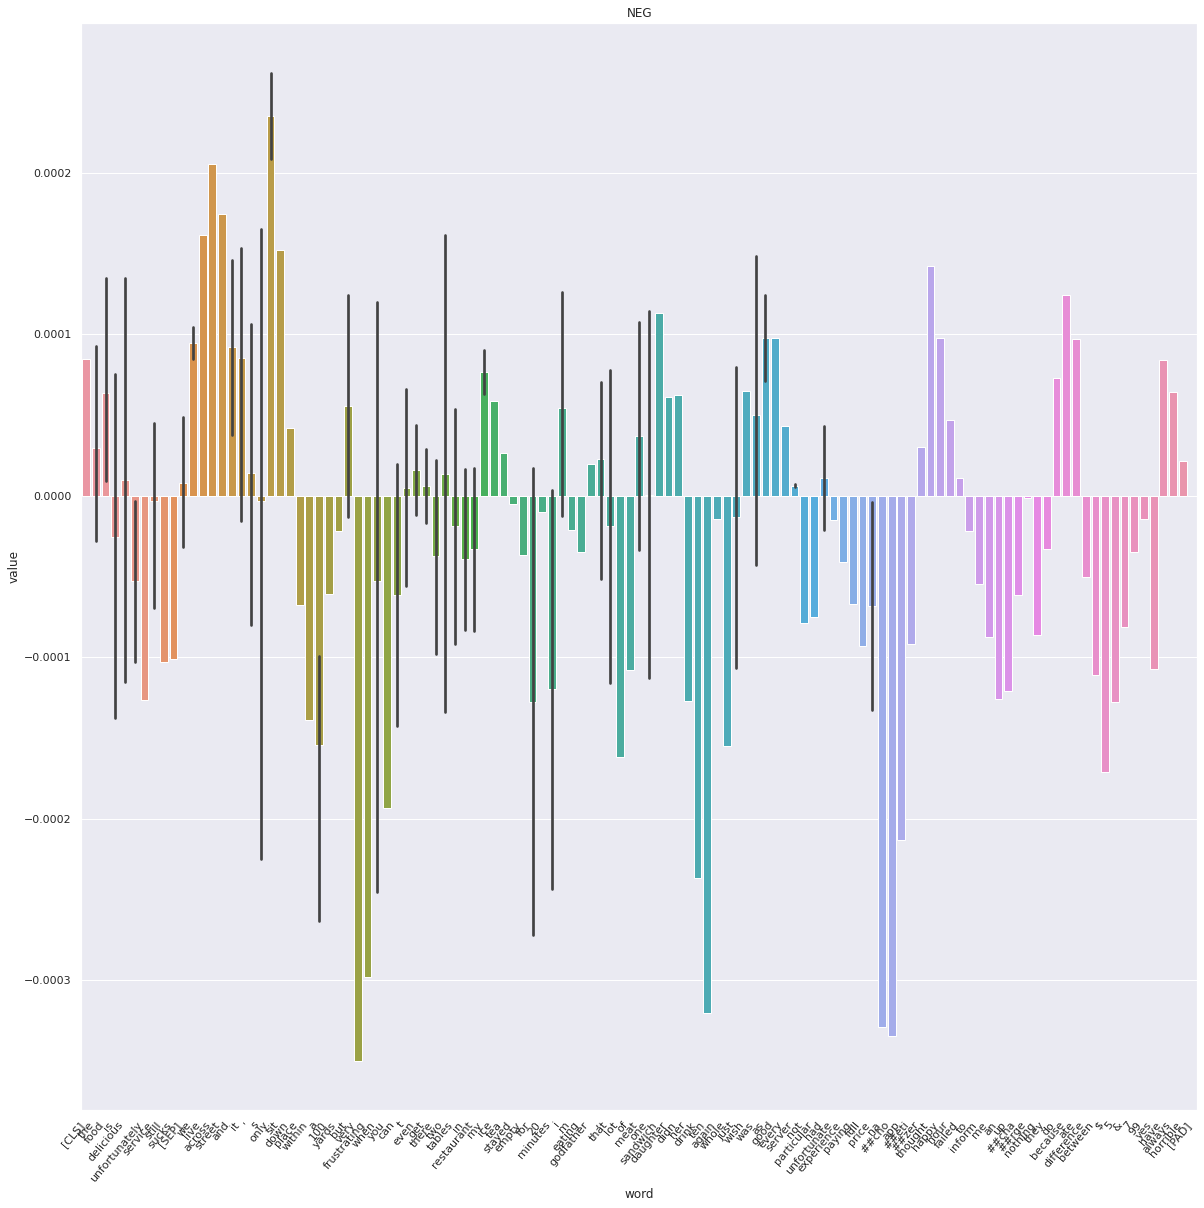

In [ ]:
for i, (inputs, labels, masks, _) in enumerate(val_loader):
    sentence = inputs.to(device)
    masks = masks.to(device)

    sentence = sentence[0].unsqueeze(0)
    masks = masks[0].unsqueeze(0)

    pred, output = grad_cam(sentence, masks).max(dim=-1) #마지막 class node중, max가져옴.
    grad_cam.zero_grad()#역전파값 모두 초기화
    pred.backward(retain_graph=True) #역전파 계산. print찍어보면 이미 cahce 다 비웠음.


    #register_hook으로 중간 gradient 붙잡아둠.
    gradients = grad_cam.get_activations_gradient()
    '''
        detach() 현재 계산 기록으로 분리됨. 이후에
        detach()는 in-place함수가 아니라 requires_grad, grad_fn이 각각 False, None인 "새로운" Tensor를 리턴한다!
    '''
    activations = grad_cam.get_activations(sentence,masks).detach()

    #global average pooling : 각 채널별로 평균 구함.
    pooled_gradients= torch.mean(gradients, dim=[0, 2])
    for k in range(gradients.shape[1]):
        activations[:, k, :] *= pooled_gradients[k]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = heatmap.view(1,-1).cpu().numpy()
    heatmap = cv2.resize(heatmap, dsize=(512,1))
    heatmap = np.multiply(heatmap,masks.cpu().numpy())
    break

pd_df=[]
for i,word in enumerate(sentence[0]):
    pd_df.append((heatmap[0][i],vocab[word]))
pd_df = pd.DataFrame(pd_df)
pd_df.columns=["value","word"]

plt.figure(figsize=(20,20))
plt.title(title_order[labels[0]])
ax=sns.barplot(x="word", y="value", data=pd_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.rcParams["xtick.labelsize"] = 10
plt.show()   